# Setup

In [1]:
import wandb
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Data

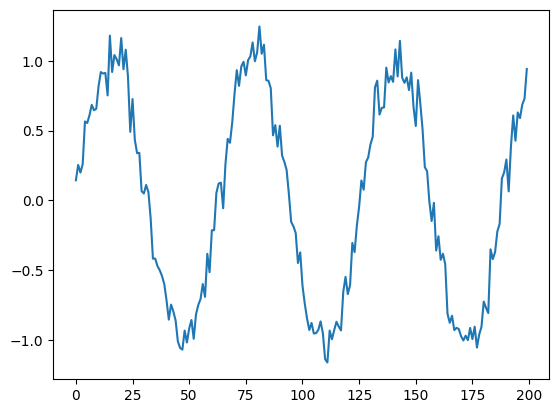

In [2]:
# Synthetic data with noisy sine wave
series = np.sin(0.1*np.arange(200)) + np.random.randn(200) * 0.1
plt.plot(series)
plt.show()

In [3]:
T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)

# Model

In [16]:
# Configure the wandb sweep
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'values': [1, 0.1, 0.01, 0.001, 0.0001]
        },
        'epochs': {
            'values': [40, 80, 100, 200]
        },
        'batch_size': {
            'values': [8, 16, 32, 64]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'rmsprop']
        },
        'activation_func': {
            'values': ['tanh', 'relu', None]
        },
    }
}

In [17]:
# Initialise sweep
sweep_id = wandb.sweep(sweep_config, project='tensorflow-test', entity='kavp')

Create sweep with ID: fqyx8yld
Sweep URL: https://wandb.ai/kavp/tensorflow-test/sweeps/fqyx8yld


In [18]:
# Mega function to define and train model and log results (used by the sweep)
def sweep_func():
    # Default hyperparameter values
    config_defaults = {
        'learning_rate': 0.001,
        'epochs': 80,
        'batch_size': 16,
        'optimizer': 'adam',
        'eager_mode': False,
        'activation_func': 'tanh',
    }

    # Initialise run
    wandb.init(config=config_defaults)

    # Variable to hold the sweep values
    config = wandb.config
    
    if config['eager_mode'] == True:
        tf.compat.v1.enable_eager_execution()
    elif config['eager_mode'] == False:
        tf.compat.v1.disable_eager_execution()
    else:
        raise ValueError('eager_mode property of wandb config could not be determined.') 

    # Create model
    inp = tf.keras.layers.Input(shape=(T, 1))
    x = tf.keras.layers.SimpleRNN(5, activation=config['activation_func'])(inp)
    x = tf.keras.layers.Dense(1)(x)

    model = tf.keras.models.Model(inp, x)

    model.compile(
        optimizer=config['optimizer'],
        loss='mse',
        metrics=None,
        run_eagerly=config['eager_mode'],
    )

    with tf.compat.v1.Session() as sess:
        r = model.fit(X[:-N//2], Y[:-N//2], validation_data=(X[-N//2:], Y[-N//2:]), epochs=config['epochs'], batch_size=config['batch_size'])
        wandb.tensorflow.log(tf.compat.v1.summary.merge_all())
        wandb.log({'loss': r.history['loss'][-1], 'val_loss': r.history['val_loss'][-1]})

        wandb_data = [[x,y] for (x,y) in zip(np.arange(0, config['epochs'], 1), r.history['loss'])]
        table = wandb.Table(data=wandb_data, columns = ["epoch", "loss"])
        wandb.log({"loss_against_epochs" : wandb.plot.line(table, "epoch", "loss", title="Training loss")})

        wandb_data = [[x,y] for (x,y) in zip(np.arange(0, config['epochs'], 1), r.history['val_loss'])]
        table = wandb.Table(data=wandb_data, columns = ["epoch", "val_loss"])
        wandb.log({"val_loss_against_epochs" : wandb.plot.line(table, "epoch", "val_loss", title="Validation loss")})

        # Save model
        model.save(os.path.join(wandb.run.dir, 'model.h5'))

In [ ]:
wandb.agent(sweep_id, sweep_func)

In [20]:
wandb.finish()

# Predictions

In [4]:
# Load a good run
good_run_path = 'kavp/tensorflow-test/opsha35j/'
run = wandb.Api().run(good_run_path)
# Load model
best_model = wandb.restore('model.h5', run_path=good_run_path)
# Load config
config = run.config

# Create model
inp = tf.keras.layers.Input(shape=(T, 1))
x = tf.keras.layers.SimpleRNN(5)(inp)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(inp, x)

model.compile(
    optimizer=config['optimizer'],
    loss='mse',
    metrics=['accuracy'],
    run_eagerly=config['eager_mode'],
)

# Load its weights into the new model
model.load_weights(best_model.name)

In [5]:
validation_target = Y[-N//2:]
validation_predictions = []
last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1,-1))[0,0]
    validation_predictions.append(p)
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - 0s 11ms/step


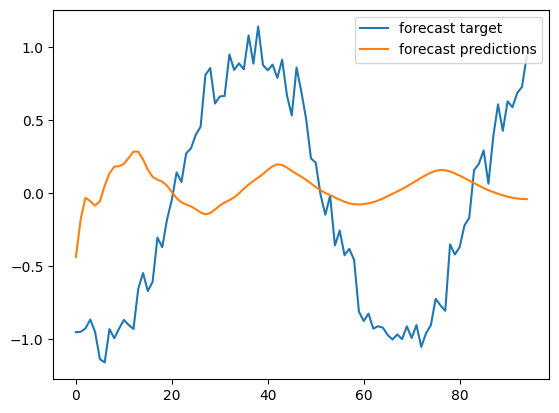

In [6]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast predictions')
plt.legend()